In [2]:
import import_ipynb
import warnings
warnings.filterwarnings('ignore')
from preprocessing import load_data
from lgb_model import lgb_model_init, lgb_model_tuned
from xgb_model import xgb_model_init, xgb_model_tuned
from cat_model import cat_model_init, cat_model_tuned
from dnn_model import dnn_epoch_50, dnn_epoch_100
from rf_model import rf_model_init,rf_model_tuned

import pandas as pd
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

importing Jupyter notebook from preprocessing.ipynb
importing Jupyter notebook from lgb_model.ipynb
importing Jupyter notebook from xgb_model.ipynb
importing Jupyter notebook from cat_model.ipynb
importing Jupyter notebook from dnn_model.ipynb
importing Jupyter notebook from rf_model.ipynb


[IterativeImputer] Completing matrix with shape (143983, 63)
[IterativeImputer] Ending imputation round 1/20, elapsed time 25.23
[IterativeImputer] Change: 4339717.71809193, scaled tolerance: 16508.0 
[IterativeImputer] Ending imputation round 2/20, elapsed time 50.44
[IterativeImputer] Change: 109178.47467921741, scaled tolerance: 16508.0 
[IterativeImputer] Ending imputation round 3/20, elapsed time 75.59
[IterativeImputer] Change: 61326.23124082783, scaled tolerance: 16508.0 
[IterativeImputer] Ending imputation round 4/20, elapsed time 101.11
[IterativeImputer] Change: 47768.54785095952, scaled tolerance: 16508.0 
[IterativeImputer] Ending imputation round 5/20, elapsed time 126.37
[IterativeImputer] Change: 34219.36234993352, scaled tolerance: 16508.0 
[IterativeImputer] Ending imputation round 6/20, elapsed time 152.27
[IterativeImputer] Change: 22454.161777217312, scaled tolerance: 16508.0 
[IterativeImputer] Ending imputation round 7/20, elapsed time 177.73
[IterativeImputer] C

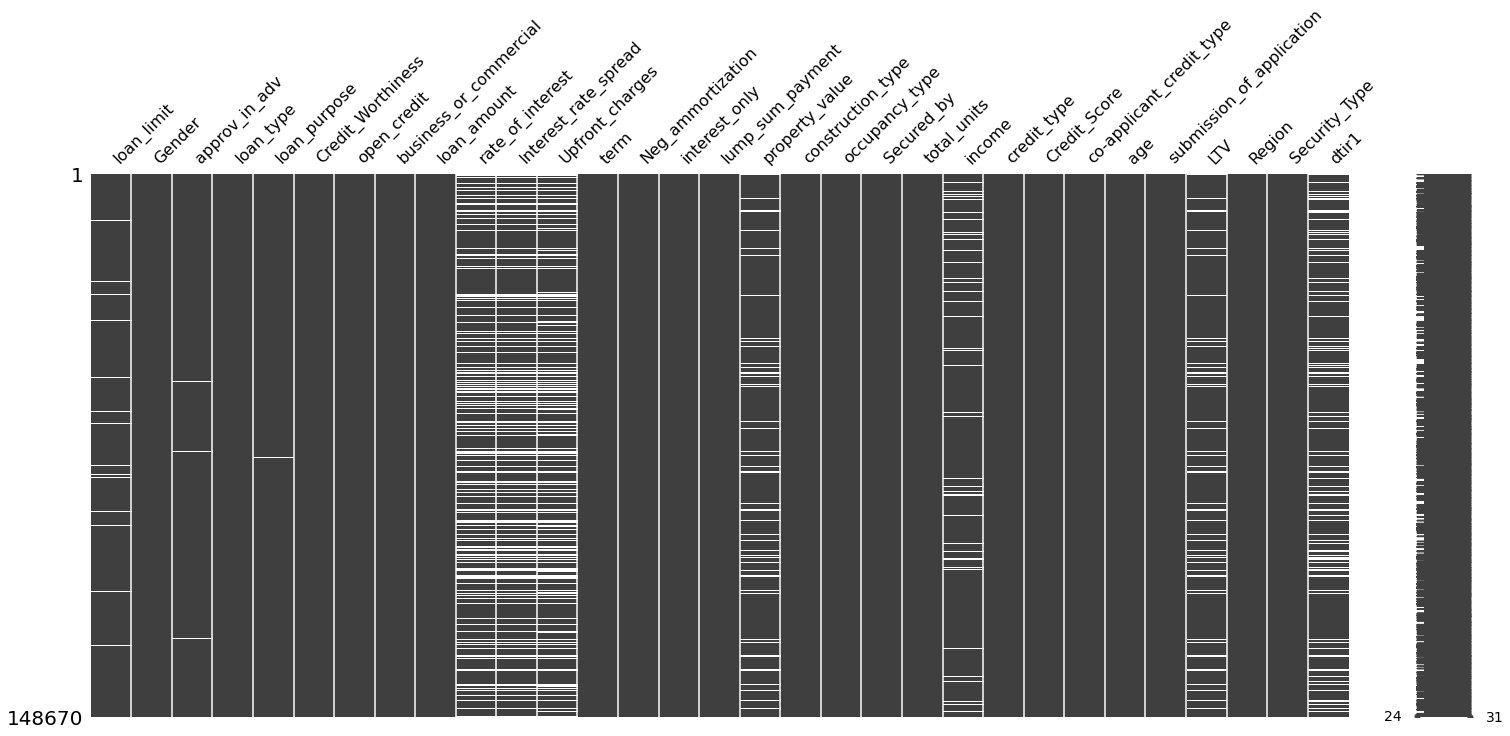

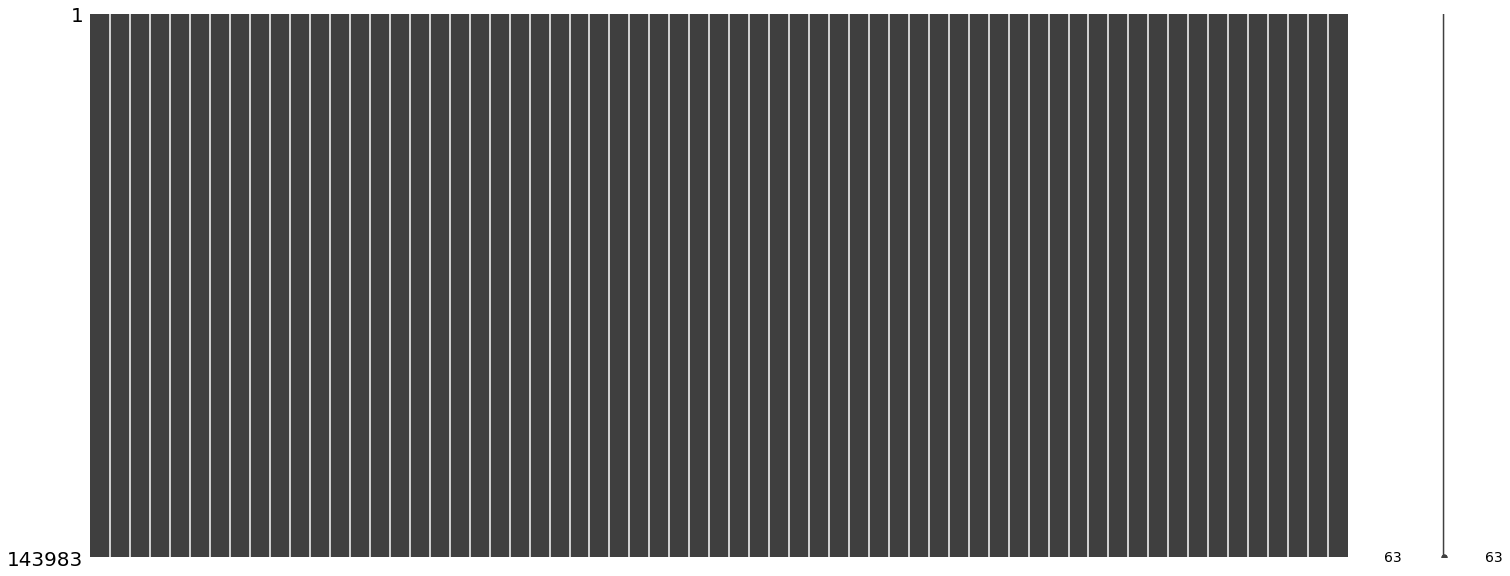

In [3]:
data,target = load_data('data/Loan_Default.csv')

In [4]:
X_train,X_test,y_train,y_test = train_test_split(data,target,train_size=0.7,random_state=2022)

In [53]:
model_dict = {'lgb_init_clf':0, 'lgb_tuned_clf':0, 'xgb_init_clf':0, 'xgb_tuned_clf':0, 'cat_init_clf':0,'cat_tuned_clf':0,
             'dnn_epoch_50_clf':0,'dnn_epoch_100_clf':0,'rf_init_clf':0,'rf_tuned_clf':0}

In [54]:
# 최종 함수

def evaluate_score(data=None,target=None):
    
    X_train,X_test,y_train,y_test=train_test_split(data,target,train_size=0.7,random_state=2022)
    
    #get_model
    get_lgb_model(X_train,y_train)
    get_xgb_model(X_train,y_train)
    get_cat_model(X_train,y_train)
    get_rf_model(X_train,y_train)
    get_dnn_model(X_train,y_train)
    score_list=list()
    i=0
    for model_name,model in model_dict.items():
        if (model_name=='dnn_epoch_50_clf') or (model_name=='dnn_epoch_100_clf'):
            pred = model.predict(X_test)
            y_pred = np.where(pred > 0.5, 1 , 0)
        else:
            y_pred=model.predict(X_test)
        
        #score list 에 모델 별 f1_score 저장
        score_list.append(mt.f1_score(y_test, y_pred, pos_label=1))
        print('----------------------------------------------------')
        if (i%2==0):
            print('before tuning-',end='')
        else:
            print('after tuning-',end='')
        print(model,'\n')
        
        #dnn 평가
        if (model_name=='dnn_epoch_50_clf') or (model_name=='dnn_epoch_100_clf'):
            #precision, recall, f1_score
            print(mt.classification_report(y_test, y_pred))
            #confusion_matrix
            matrix = pd.DataFrame(mt.confusion_matrix(y_test, y_pred),columns=['pred_no','pred_yes'])
            matrix.index = ['actual_no','actual_yes']
            print(matrix)
            auc_roc_score(model,model_name,X_test,y_test,pred)
            
        # 랜덤포레스트, xgb, cat, lightgbm 평가
        else:
            #model_score 함수 호출
            model_score(model,X_train,y_train,X_test,y_test,y_pred)
            #auc_roc_score 함수 호출
            auc_roc_score(model,model_name,X_test,y_test,y_pred)
            #stratified_kfold_score 함수 호출
            stratified_kfold_score(model,data,target)
        i+=1
        
    print('----------------------------------------------------')
    # 튜닝 전/후로 모델에 대한 f1_score 데이터프레임으로 비교
    
    
    score_df=pd.DataFrame(np.array(score_list).reshape(5,2),
                          columns=['before tuning','after tuning'],index=['lgbm','xgb','cat','random_forest','dnn'])
    print(score_df)

In [55]:
def get_lgb_model(X_train=None,y_train=None):
    
    print('--------------------')
    print('lgb_init')
    print('--------------------')
    lgb_init_clf = lgb_model_init(X_train,y_train)
    
    print('--------------------')
    print('lgb_tuned')
    print('--------------------')
    lgb_tuned_clf = lgb_model_tuned(X_train,y_train)
    
    model_dict['lgb_init_clf'] = lgb_init_clf
    model_dict['lgb_tuned_clf'] = lgb_tuned_clf

In [56]:
def get_xgb_model(X_train=None,y_train=None):

    print('--------------------')
    print('xgb_init')
    print('--------------------')
    xgb_init_clf = xgb_model_init(X_train,y_train)
    
    print('--------------------')
    print('xgb_tuned')
    print('--------------------')
    xgb_tuned_clf = xgb_model_tuned(X_train,y_train)
    
    model_dict['xgb_init_clf'] = xgb_init_clf
    model_dict['xgb_tuned_clf'] = xgb_tuned_clf

In [57]:
def get_cat_model(X_train=None,y_train=None):
    
    print('--------------------')
    print('cat_init')
    print('--------------------')
    cat_init_clf = cat_model_init(X_train,y_train)
    
    print('--------------------')
    print('cat_tuned')
    print('--------------------')
    cat_tuned_clf = cat_model_tuned(X_train,y_train)
    
    model_dict['cat_init_clf'] = cat_init_clf
    model_dict['cat_tuned_clf'] = cat_tuned_clf

In [58]:
def get_rf_model(X_train=None,y_train=None):

    print('--------------------')
    print('rf_init')
    print('--------------------')
    rf_init_clf = rf_model_init(X_train,y_train)
    
    print('--------------------')
    print('rf_tuned')
    print('--------------------')
    rf_tuned_clf = rf_model_tuned(X_train,y_train)
    
    model_dict['rf_init_clf'] = rf_init_clf
    model_dict['rf_tuned_clf'] = rf_tuned_clf

In [59]:
def get_dnn_model(X_train=None,y_train=None):
    global dnn_epoch_50_clf,dnn_epoch_100_clf
    
    print('--------------------')
    print('dnn_epoch_50')
    print('--------------------')
    dnn_epoch_50_clf = dnn_epoch_50(X_train,y_train)
    
    print('--------------------')
    print('dnn_epoch_100')
    print('--------------------')
    dnn_epoch_100_clf = dnn_epoch_100(X_train,y_train)
    
    model_dict['dnn_epoch_50_clf'] = dnn_epoch_50_clf
    model_dict['dnn_epoch_100_clf'] = dnn_epoch_100_clf

In [60]:
def auc_roc_score(model=None,model_name='.',X_test=None,y_test=None,y_pred=None):
    global dnn_epoch_50_clf,dnn_epoch_100_clf
    
    if (model==dnn_epoch_50_clf) or (model==dnn_epoch_100_clf):
        pred_positive_proba=y_pred
    else:
        pred_positive_proba=model.predict_proba(X_test)[:,1]
    roc_auc_score=mt.roc_auc_score(y_test,y_pred)
    
    #roc-auc curve 시각화
    fprs, tprs, thresholds=mt.roc_curve(y_test,pred_positive_proba,pos_label=1)
    plt.xticks(np.round(np.arange(0,1, 0.1),2))
    plt.title(model_name+' roc-auc curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.plot(fprs,tprs,label='ROC')
    #plt.show()
    
    save_name = 'graph/'+model_name+'.png'
    plt.savefig(save_name)

    print('\tAuc: ', format(roc_auc_score,'.4f'),'\n')

In [61]:
def model_score(model=None,X_train=None,y_train=None,X_test=None,y_test=None,y_pred=None):
    print("\tTrain_Accuracy : ", model.score(X_train, y_train))
    print("\tTest_Accuracy : ", model.score(X_test, y_test), '\n')

    accuracy = mt.accuracy_score(y_test, y_pred)
    recall = mt.recall_score(y_test, y_pred, pos_label=1)
    precision = mt.precision_score(y_test, y_pred, pos_label=1)
    f1_score = mt.f1_score(y_test, y_pred, pos_label=1)
    matrix = pd.DataFrame(mt.confusion_matrix(y_test, y_pred),columns=['pred_no','pred_yes'])
    matrix.index = ['actual_no','actual_yes']
    
    print('\tAccuracy: ', format(accuracy,'.4f'),'\n')
    print('\tRecall: ', format(recall,'.4f'),'\n')
    print('\tPrecision: ', format(precision,'.4f'),'\n')
    print('\tF1_score: ', format(f1_score,'.4f'),'\n')
    print('\tConfusion Matrix:','\n', matrix)

In [62]:
def stratified_kfold_score(model=None,data=None,target=None):

    #stratified-kfold
    str_kfold=StratifiedKFold(n_splits=5,shuffle=True)
    
    #cross validation
    cv_score=cross_val_score(model,data,target,cv=str_kfold,scoring='accuracy')
    print('\tCross validation score: ',cv_score)
    print('\tCross validation score(mean): ', format(cv_score.mean(),'.4f'))

# 함수 잘 돌아가는지 테스트 부분

--------------------
lgb_init
--------------------
--------------------
lgb_tuned
--------------------
Fitting 4 folds for each of 162 candidates, totalling 648 fits
--------------------
xgb_init
--------------------
--------------------
xgb_tuned
--------------------
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[17:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--------------------
cat_init
--------------------
--------------------
cat_tuned
--------------------
Fitting 4 folds for each of 18 candidates, totalling 72 fits
--------------------
rf_init
--------------------
--------------------
rf_tuned
-----------

591/591 [==============================] - 1s 1ms/step - loss: 0.2017 - accuracy: 0.9110 - val_loss: 0.1371 - val_accuracy: 0.9398
--------------------
dnn_epoch_100
--------------------
Epoch 1/100
591/591 [==============================] - 2s 2ms/step - loss: 1.1096 - accuracy: 0.6917 - val_loss: 0.6137 - val_accuracy: 0.6681
Epoch 2/100
591/591 [==============================] - 2s 3ms/step - loss: 0.5184 - accuracy: 0.7919 - val_loss: 0.4371 - val_accuracy: 0.8498
Epoch 3/100
591/591 [==============================] - 1s 2ms/step - loss: 0.4432 - accuracy: 0.8341 - val_loss: 0.4856 - val_accuracy: 0.8067
Epoch 4/100
591/591 [==============================] - 1s 2ms/step - loss: 0.4004 - accuracy: 0.8501 - val_loss: 0.5035 - val_accuracy: 0.7622
Epoch 5/100
591/591 [==============================] - 1s 1ms/step - loss: 0.4105 - accuracy: 0.8445 - val_loss: 0.3718 - val_accuracy: 0.8626
Epoch 6/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3779 - accuracy: 0.85

591/591 [==============================] - 1s 2ms/step - loss: 0.1345 - accuracy: 0.9357 - val_loss: 0.0977 - val_accuracy: 0.9606
Epoch 57/100
591/591 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.9406 - val_loss: 0.1934 - val_accuracy: 0.8936
Epoch 58/100
591/591 [==============================] - 1s 1ms/step - loss: 0.1317 - accuracy: 0.9380 - val_loss: 0.1282 - val_accuracy: 0.9412
Epoch 59/100
591/591 [==============================] - 1s 1ms/step - loss: 0.1341 - accuracy: 0.9379 - val_loss: 0.1199 - val_accuracy: 0.9388
Epoch 60/100
591/591 [==============================] - 1s 1ms/step - loss: 0.1320 - accuracy: 0.9379 - val_loss: 0.1373 - val_accuracy: 0.9198
Epoch 61/100
591/591 [==============================] - 1s 1ms/step - loss: 0.1257 - accuracy: 0.9398 - val_loss: 0.1298 - val_accuracy: 0.9373
Epoch 62/100
591/591 [==============================] - 1s 2ms/step - loss: 0.1244 - accuracy: 0.9410 - val_loss: 0.0922 - val_accuracy: 0.9621
Epoch

	Test_Accuracy :  0.9991202685496007 

	Accuracy:  0.9991 

	Recall:  0.9979 

	Precision:  0.9985 

	F1_score:  0.9982 

	Confusion Matrix: 
             pred_no  pred_yes
actual_no     32702        16
actual_yes       22     10455
	Auc:  0.9987 

	Cross validation score:  [0.99951384 0.99927076 0.99930548 0.99923601 0.99920128]
	Cross validation score(mean):  0.9993
----------------------------------------------------
after tuning-XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=

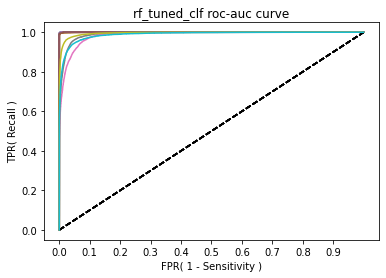

In [63]:
# 최종 함수
evaluate_score(data,target)